In [1]:
import gym
from gym import wrappers
import time
from IPython.display import clear_output
import matplotlib
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle

In [2]:
def myrender(self, title=''):
    plt.title(title)
    plt.imshow(self.old_render(mode='rgb_array'))
    plt.axis('off')
    plt.show()
    clear_output(wait=True)
    time.sleep(1/60)
    
def wrapper_gymenv(env):
    env.old_render = env.render
    env.render = lambda : myrender(env)
    return env

In [3]:
def saveAgent(agent, fileName):
    with open(fileName, 'wb') as f:
        pickle.dump(agent, f)
    return fileName
    
def loadAgent(fileName):
    with open(fileName, 'rb') as f:
        agent = pickle.load(f)
    return agent

In [4]:
class DQN(nn.Module):
    def __init__(
        self, observation_space, action_space, device,
        lr=0.05, hidden_size=32, buffer_size=5000
    ):
        super(DQN, self).__init__()
        
        self.observation_space = observation_space
        if len(observation_space.shape) > 0:
            self.osize = observation_space.shape[0]
        else:
            raise NotImplementedError()
        
        self.action_space = action_space
        if len(action_space.shape) == 0:
            self.asize = action_space.n
        else:
            raise NotImplementedError()
        
        self.hidden_size = hidden_size
        
        def __DQN():
            return nn.Sequential(
                nn.Linear(self.osize, self.hidden_size),
                nn.ReLU(inplace=True),
                nn.Linear(self.hidden_size, self.asize, bias=False),
            )
        
        self.device = device
        self.eval_net = __DQN().to(self.device)
        self.target_net = __DQN().to(self.device)
        
        
        self.metrics = []
        # s, a, r, s_next
        self.buffer = np.zeros((buffer_size, self.osize + 1 + 1 + self.osize+1))
        self.buffer_size = buffer_size
        self.buffer_count = 0
        
        self.eval_optimizer = torch.optim.RMSprop(self.eval_net.parameters(), lr=lr)
        
        self.criterion = F.smooth_l1_loss
        
        self.update()
    
    def initweight(self):
        for m in self.eval_net.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.constant_(m.weight.data, 0.1)
                if m.bias is not None:
                    torch.nn.init.constant_(m.bias.data, 0.1)
    
    def forward(self, observation, observation_next):
        observation = observation.float()
        observation_next = observation_next.float()
        # return Q(s, a)
        return self.eval_net(observation), self.target_net(observation_next).detach()
    
    # update target net by evaluation net
    def update(self):
        self.target_net.load_state_dict(self.eval_net.state_dict())
        
    def clone(self):
        newone = DQN(self.observation_space, self.action_space, self.device)
        newone.eval_net.load_state_dict(self.eval_net.state_dict())
        newone.update()
        
        return newone
    
    # get action from observation
    def think_(self, observation):
        observation = torch.tensor(observation).to(self.device).float()
        with torch.no_grad():
            return self.eval_net(observation).detach()
    def think(self, observation):
        return torch.argmax(self.think_(observation)).item()
    
    def store_transition(self, s, a, r, s_next, done):
        transition = np.hstack((s, [a, r], s_next, done))
        # store
        self.buffer[self.buffer_count%self.buffer_size, : ] = transition
        
        self.buffer_count += 1
    
    def store_metrics(self, total_reward, loss, epsilon):
        self.metrics.append( (total_reward, loss, epsilon) )
    
    def learn(self, batch_size, gamma=0.95):
        
        # pick data from buffer
        pick_i = np.random.choice(self.buffer_size if self.buffer_count > self.buffer_size else self.buffer_count, size=batch_size)
        x = self.buffer[pick_i, :]
        
        # clear grad
        self.eval_optimizer.zero_grad()
        
        # only use state
        q_eval, q_target = self( torch.tensor( x[:, :self.osize] ).to(self.device) , torch.tensor( x[:, -(self.osize+1):-1] ).to(self.device)) 
        
        # x[:, -1] done list
        q_target_value = torch.max(q_target, dim=1)[0].detach()
        q_target_value[np.argwhere(x[:,-1] == 1).reshape(-1)] = 0.0
           
        #print(q_target_value)
        #print(np.argwhere(x[:,-1] == 1)[0])
        
        y = q_eval.clone().detach()
        # set y = r + \gamma max_a( Q_target(s', a) )
        y[np.arange(batch_size), x[:, self.osize]]  = torch.tensor(x[:, self.osize+1]).float() + (gamma * q_target_value)
        
        loss = self.criterion(q_eval, y)
        # update weight
        loss.backward()
        
        # prevent too huge grad
        #for param in self.eval_net.parameters():
        #    param.grad.data.clamp_(-1, 1)
        self.eval_optimizer.step()
        
        return loss

In [5]:
def play(agent, show=True):
    s = env.reset()
    score = 0.0
    if show:
        env.render()
    while True:
        a = agent.think(s)
        q = agent.think_(s)
        
        s, r, done, _ = env.step(a)
        #print(r)
        score += r
        if show:
            print('score : {:.0f}, action : {}, Q : {}'.format(score, a, q))
            env.render()
        if done:
            break
    return score

In [6]:
# training procedure
def train(
    agent, epoch_size, batch_size, update_size, 
    epsilon_start=1.0, epsilon_end=0.1, epsilon_decay=995):
    
    #epsilon *= epsilon_decay**len(agent.metrics)
    best_agent = agent.clone()
    best_score = 0.0
    
    for epoch in range(len(agent.metrics), epoch_size):
        # play
        observation = env.reset()
        score = 0.0
        loss_total = []
        
        epsilon_thr = epsilon_end + ( (epsilon_start - epsilon_end) * np.exp(-1. * epoch / epsilon_decay) )
            
        while True:
            # choose action
            #epsilon_thr = epsilon_end + ( (epsilon_start - epsilon_end) * np.exp(-1. * step / epsilon_decay) )
            if np.random.rand() < epsilon_thr:
                #action = env.action_space.sample()
                action = np.random.randint(agent.asize)
            else:
                action = agent.think(observation)
            
            # do action
            observation_next, reward, done, info = env.step(action)
            
            score += reward
            # if end game get negative reward
            if done:
                reward = -10
                
            # store
            agent.store_transition(observation, action, reward, observation_next, done)
            
            
            # learn
            #if batch_size < agent.buffer_count:
            if True:
                loss = agent.learn(batch_size)
                loss_total.append( loss.item() )
                
                
            # update
            #if agent.buffer_count % update_size == 0:
            #    agent.update()
            
            if done:
                break
            
            #epsilon *= epsilon_decay
        
        #loss = agent.learn(batch_size)
        
        test_score = [play(agent, show=False) for _ in range(100)]
        test_score = np.mean(test_score)
        
        if test_score > best_score:
            best_agent = agent.clone()
            best_score = test_score
        
        # update
        if epoch % update_size == 0:
            agent.update()
        
        # metrics
        loss_total = np.average(loss_total) if len(loss_total) > 0 else 0.0
        agent.store_metrics(test_score, loss_total, epsilon_thr)
        
        # epsilon *= epsilon_decay
    #print(best_agent)
    return best_agent

In [7]:
env = gym.make('CartPole-v0')
env = wrapper_gymenv(env)
env._max_episode_steps = 500

agent = DQN(env.observation_space, env.action_space, torch.device("cpu"))
save_agent_init = agent.clone()
agent

DQN(
  (eval_net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=32, out_features=2, bias=False)
  )
  (target_net): Sequential(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=32, out_features=2, bias=False)
  )
)

In [8]:
agent = save_agent_init.clone()

In [9]:
best_agent = train(agent, 1000, 128, 50)

In [34]:
def showMetrics(agent):
    m = np.array(agent.metrics)
    
    plt.title('Reward Curve')
    plt.plot(m[:, 0], color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.show()
    
    plt.title('Loss')
    plt.plot(m[:, 1], color='yellow')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    
    plt.plot(m[:, 2], color='purple')

17440 5000


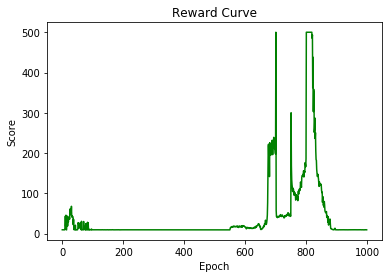

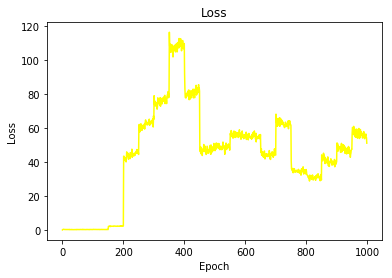

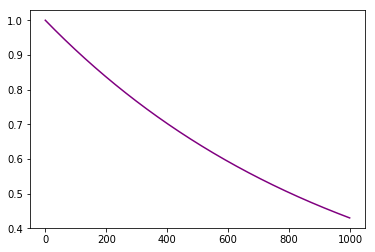

In [35]:
print(agent.buffer_count, agent.buffer_size)
showMetrics(agent)

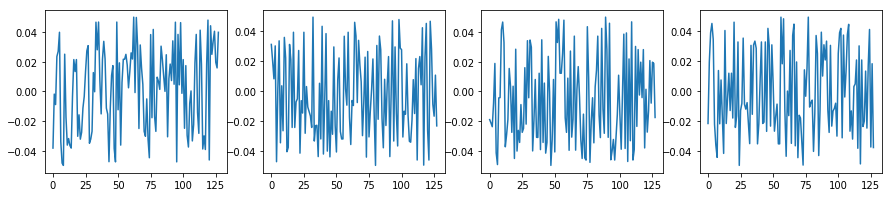

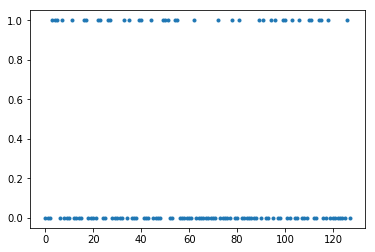

In [12]:
pick_i = np.random.choice(agent.buffer_size if agent.buffer_count > agent.buffer_size else agent.buffer_count, size=128)
plt.figure(figsize=(15,3))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.plot(agent.buffer[pick_i, i])
plt.show()

plt.plot(agent.buffer[pick_i, 4],'.')
#plt.plot(agent.buffer[pick_i, 5])
#plt.plot(agent.buffer[pick_i, -1], '.')

score : 500, action : 1, Q : tensor([460.9447, 470.3440])


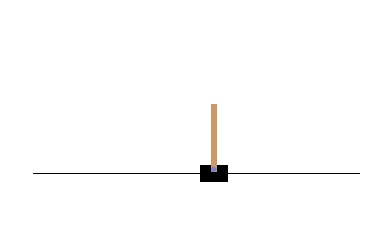

In [13]:
_ = play(best_agent)

tensor([252.4714, 218.3141])


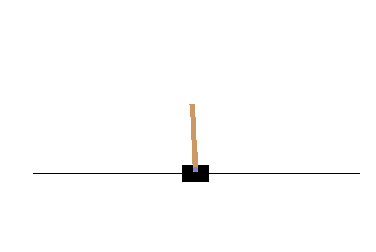

In [14]:
o = env.reset()
print(agent.think_(o))
env.render()

In [15]:
saveAgent(best_agent, 'agent-dqn-best2.pkl')

'agent-dqn-best2.pkl'

In [16]:
def testAgent(agent, times = 100):
    score_t = 0.0
    for i in range(times):
        score_t += play(agent, show=False)
    return score_t / times

In [45]:
testAgent(best_agent)

500.0